In [1]:
%reset
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import torch

import defmod as dm

torch.set_default_tensor_type(torch.DoubleTensor)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
source = dm.sampling.load_and_sample_greyscale("../data/density_a.png", threshold=0.5, centered=True)
target = dm.sampling.load_and_sample_greyscale("../data/density_b.png", threshold=0.5, centered=True)

In [3]:
aabb = dm.usefulfunctions.AABB.build_from_points(source[0])
aabb_total = dm.usefulfunctions.AABB.build_from_points(torch.cat([source[0], target[0]]))

In [4]:
sigma = 0.1
step = sigma
x, y = torch.meshgrid([torch.arange(aabb.xmin-sigma, aabb.xmax+sigma, step=step), torch.arange(aabb.ymin-sigma, aabb.ymax+sigma, step=step)])
gd = dm.usefulfunctions.grid2vec(x, y).contiguous().view(-1).requires_grad_()

sigma1 = 0.02
step1 = sigma1
x1, y1 = torch.meshgrid([torch.arange(aabb.xmin-sigma1, aabb.xmax+sigma1, step=step1), torch.arange(aabb.ymin-sigma1, aabb.ymax+sigma1, step=step1)])
gd1 = dm.usefulfunctions.grid2vec(x1, y1).contiguous().view(-1).requires_grad_()

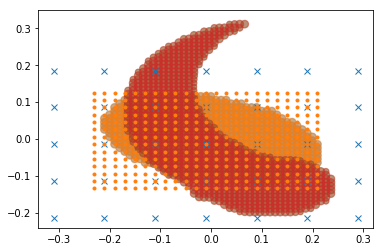

In [5]:
dm.usefulfunctions.plot_tensor_scatter(source, alpha=0.4)
dm.usefulfunctions.plot_tensor_scatter(target, alpha=0.4)
plt.plot(gd.detach().view(-1, 2)[:, 1].numpy(), gd.detach().view(-1, 2)[:, 0].numpy(), 'x')
plt.plot(gd1.detach().view(-1, 2)[:, 1].numpy(), gd1.detach().view(-1, 2)[:, 0].numpy(), '.')
plt.show()

In [6]:
print(gd.view(-1, 2).shape)
print(gd1.view(-1, 2).shape)
print(source[0].shape)

torch.Size([35, 2])
torch.Size([322, 2])
torch.Size([784, 2])


In [7]:
source[1].shape


torch.Size([784])

In [9]:
trans = dm.implicitmodules.ImplicitModule0(dm.manifold.Landmarks(2, gd.view(-1, 2).shape[0], gd=gd,), sigma, 0.001)
trans1 = dm.implicitmodules.ImplicitModule0(dm.manifold.Landmarks(2, gd1.view(-1, 2).shape[0], gd=gd1), sigma1, 0.001)
my_model = dm.models.ModelCompoundWithPointsRegistration(source, [trans, trans1], [True, True])
costs = my_model.fit(target, max_iter=30, l=2000., lr=1e-6, log_interval=1)

TypeError: __init__() missing 1 required positional argument: 'attachement'

In [ ]:
out = my_model()
%matplotlib qt5
plt.subplot(1, 2, 1)
dm.usefulfunctions.plot_tensor_scatter(target, alpha=0.4)
dm.usefulfunctions.plot_tensor_scatter(source, alpha=0.4)
ax = plt.subplot(1, 2, 2)
dm.usefulfunctions.plot_tensor_scatter(target, alpha=0.4)
dm.usefulfunctions.plot_tensor_scatter(out[0], alpha=0.4)
plt.plot(my_model.shot_manifold[1].gd.detach().view(-1, 2)[:, 1].numpy(), my_model.shot_manifold[1].gd.detach().view(-1, 2)[:, 0].numpy(), '.')
plt.plot(my_model.shot_manifold[2].gd.detach().view(-1, 2)[:, 1].numpy(), my_model.shot_manifold[2].gd.detach().view(-1, 2)[:, 0].numpy(), '.')
gridpos_x, gridpos_y = my_model.compute_deformation_grid(torch.tensor([aabb_total.xmin, aabb_total.ymin]), torch.tensor([aabb_total.width, aabb_total.height]), torch.tensor([16, 16]))
dm.usefulfunctions.plot_grid(ax, gridpos_y.detach().numpy(), gridpos_x.detach().numpy(), color='C0')
plt.show()


In [ ]:
plt.plot(range(0, len(costs)), costs)
plt.show()